In [6]:
import torch
from torch import nn

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [8]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists")
else:
    print(f"Creating {image_path} directory")
    image_path.mkdir(parents = True, exist_ok= True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r")as zip_ref:
  print("Unzipping pizza, steak, sushi data")
  zip_ref.extractall(image_path)

Creating data/pizza_steak_sushi directory
Unzipping pizza, steak, sushi data


In [9]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [10]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/test/sushi/1172255.jpg
The image is of class: sushi
The image height is: 383
The image width is: 512


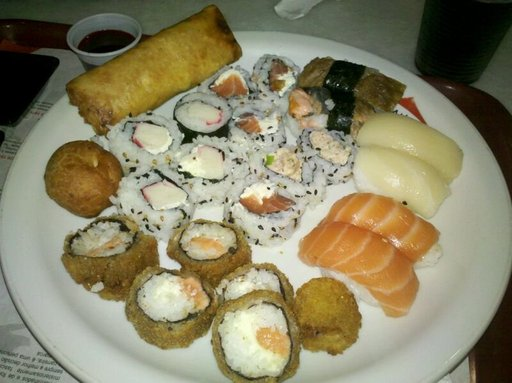

In [11]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"The image is of class: {image_class}")
print(f"The image height is: {img.height}")
print(f"The image width is: {img.width}")
img


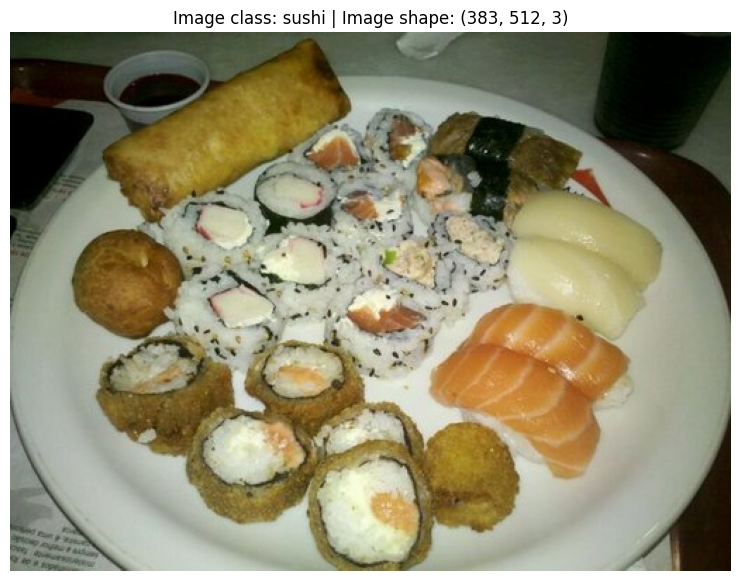

In [12]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False);

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [14]:
train_data = datasets.ImageFolder(root = train_dir,
                                  )
test_data = datasets.ImageFolder(root = test_dir,
                                  )
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train,
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test)

In [15]:
simple_transform_0 = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [18]:
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [24]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [20]:
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform,
                                         target_transform=None)
test_data_simple = datasets.ImageFolder(root = test_dir,
                                         transform=simple_transform,
                                         target_transform=None)
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)
train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x792cc6057680>,
 <torch.utils.data.dataloader.DataLoader at 0x792cbcbc8530>)

In [21]:
img, label = next(iter(train_dataloader_simple))
print({img.shape})
print({label.shape})

{torch.Size([32, 3, 64, 64])}
{torch.Size([32])}


In [22]:
class TinyVGG(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.BatchNorm2d(hidden_units),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.BatchNorm2d(hidden_units),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.BatchNorm2d(hidden_units),
      nn.ReLU(),
      nn.Conv2d(in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.BatchNorm2d(hidden_units),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Dropout(p=0.5),
      nn.Linear(in_features=hidden_units*16*16,
                out_features=output_shape)
    )
  def forward(self,x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [25]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape =3,
                   hidden_units =32,
                   output_shape = len(class_names))
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0):

In [26]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary
summary(model_0,input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 32, 64, 64]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 64, 64]           64
│    └─ReLU: 2-3                         [1, 32, 64, 64]           --
│    └─Conv2d: 2-4                       [1, 32, 64, 64]           9,248
│    └─BatchNorm2d: 2-5                  [1, 32, 64, 64]           64
│    └─ReLU: 2-6                         [1, 32, 64, 64]           --
│    └─MaxPool2d: 2-7                    [1, 32, 32, 32]           --
├─Sequential: 1-2                        [1, 32, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 32, 32, 32]           9,248
│    └─BatchNorm2d: 2-9                  [1, 32, 32, 32]           64
│    └─ReLU: 2-10                        [1, 32, 32, 32]           --
│    └─C

In [27]:
import torch
import torch.nn as nn

def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = 'cpu',
):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    #print(f"Train loss: {train_loss : .5f}  |  Train acc: {train_acc: .2f}%")
    return train_loss, train_acc

In [28]:
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = 'cpu',
):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        #print(f"Test loss: {test_loss: .4f} | Test acc: {test_acc: .4f}")
    return test_loss, test_acc

In [29]:
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = 'cpu',
):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss: .4f} | Test acc: {test_acc: .4f}")
    return test_loss, test_acc

In [30]:
from tqdm.auto import tqdm

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.dataloader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
    device: torch.device = device,
):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device,
        )
        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device,
        )
        print(
            f"Epoch:{epoch} | Train loss: {train_loss: .4f} | Train acc:{train_acc: .4f} | Test loss:{test_loss: .4f} | Test acc: {test_acc: .4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [31]:
NUM_EPOCHS = 25
model_0 = TinyVGG(input_shape=3,
                   hidden_units=32,
                   output_shape=len(train_data.classes))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr = 0.0003,
                             weight_decay=1e-4)
from timeit import default_timer as timer
start_time = timer()
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device
                        )
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Test loss:  1.1375 | Test acc:  19.7917
Epoch:0 | Train loss:  1.5434 | Train acc: 30.8594 | Test loss: 1.1375 | Test acc:  19.7917
Test loss:  1.2512 | Test acc:  19.7917
Epoch:1 | Train loss:  1.4526 | Train acc: 36.3281 | Test loss: 1.2512 | Test acc:  19.7917
Test loss:  1.1128 | Test acc:  31.0606
Epoch:2 | Train loss:  1.1118 | Train acc: 44.5312 | Test loss: 1.1128 | Test acc:  31.0606
Test loss:  1.0454 | Test acc:  39.2992
Epoch:3 | Train loss:  1.2490 | Train acc: 43.7500 | Test loss: 1.0454 | Test acc:  39.2992
Test loss:  1.2134 | Test acc:  33.2386
Epoch:4 | Train loss:  0.7750 | Train acc: 63.6719 | Test loss: 1.2134 | Test acc:  33.2386
Test loss:  0.8910 | Test acc:  57.6705
Epoch:5 | Train loss:  0.7822 | Train acc: 70.7031 | Test loss: 0.8910 | Test acc:  57.6705
Test loss:  0.9217 | Test acc:  61.7424
Epoch:6 | Train loss:  0.6118 | Train acc: 76.9531 | Test loss: 0.9217 | Test acc:  61.7424
Test loss:  0.9315 | Test acc:  52.6515
Epoch:7 | Train loss:  0.6603 | Trai

In [32]:
model_0_results

{'train_loss': [1.5433586239814758,
  1.4525790959596634,
  1.1118351817131042,
  1.2490454092621803,
  0.7750001884996891,
  0.7822427153587341,
  0.6118471557274461,
  0.660334300249815,
  0.905688002705574,
  0.8482655137777328,
  0.6092128772288561,
  0.6416684500873089,
  0.6136574856936932,
  0.6257587671279907,
  0.6150066182017326,
  0.5289430059492588,
  0.4989500120282173,
  0.7109241373836994,
  0.9308665096759796,
  0.5313789751380682,
  0.6826706565916538,
  0.6324213445186615,
  0.5431745294481516,
  0.44655305333435535,
  0.5328259654343128],
 'train_acc': [30.859375,
  36.328125,
  44.53125,
  43.75,
  63.671875,
  70.703125,
  76.953125,
  72.65625,
  62.890625,
  58.984375,
  72.265625,
  76.171875,
  67.96875,
  77.34375,
  81.25,
  78.90625,
  80.859375,
  67.578125,
  63.28125,
  78.515625,
  61.71875,
  63.671875,
  78.515625,
  84.765625,
  72.65625],
 'test_loss': [1.1375152667363484,
  1.2511721849441528,
  1.1127778093020122,
  1.0454269448916118,
  1.21341105

In [33]:
from typing import Dict, List
import matplotlib.pyplot as plt
def plot_loss_curves(results: Dict[str, List[float]]):
  """ Plots training curves of a results dictionary. """
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  epochs = range(len(results["train_loss"]))
  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

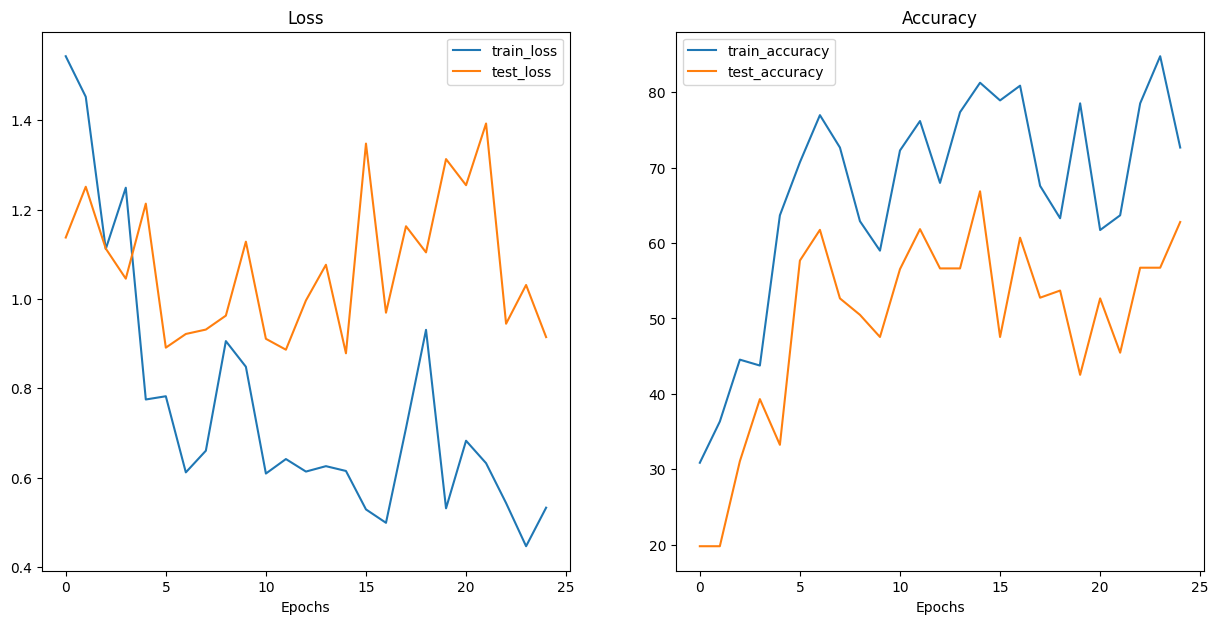

In [34]:
plot_loss_curves(model_0_results)